In [1]:
from qiskit import Aer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import SpinMapper, DirectMapper, LinearMapper, JordanWignerMapper
from qiskit.opflow import X, Y, Z, I
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import VQEUCCFactory

from qiskit.algorithms import VQE
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit

import pylab
import numpy as np
import retworkx as rx
from qiskit_nature.problems.second_quantization.lattice import (
    BoundaryCondition,
    IsingModel,
    FermiHubbardModel,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)

from matplotlib.pyplot import figure
import time

Numpy 1.16 has memory leak bug  https://github.com/numpy/numpy/issues/13808
It is recommended to downgrade to numpy 1.15 or older


In [2]:
def findGroundState(pauliSumOp):
    return min(np.linalg.eigh(pauliSumOp.to_matrix())[0])

#Converts SpinOp to PauliSumOp
def convertSpin(ham):
    result = None
    spins = [I, Z, Y, X]
    for c, x, y, z in zip(ham._coeffs, ham.x, ham.y, ham.z):
        spin = x * 3 + y * 2 + z
        pauli = spins[spin[0]]
        for n in range(1, ham.register_length):
            pauli ^= spins[spin[n]]
        pauli *= c
        result = result + pauli if result else pauli
    return result

def makeLatticeIsing(size):
    lattice = LineLattice(size, boundary_condition=BoundaryCondition.PERIODIC)

    t = -1.0  # the interaction parameter corresponds to Z
    v = 1.0  # the onsite potential corresponds to X

    ising = IsingModel.uniform_parameters(
        lattice=lattice,
        uniform_interaction=t, #interaction strength -- "hopping term"
        uniform_onsite_potential=v
    )
    return convertSpin(ising.second_q_ops())

def makeAnsatz(reps = 1, skip = True):
    return TwoLocal(
            rotation_blocks=["rx"],
            entanglement_blocks="rzz",
            entanglement="circular",
            skip_final_rotation_layer = skip,
            reps = reps,
            parameter_prefix="y",)

def findMin(ansatz, reps):
    vqe_solver = VQE(
    ansatz = ansatz,
    quantum_instance=QuantumInstance(Aer.get_backend("aer_simulator_statevector")),)
    
    results = np.full(n, None)
    groundStates = np.full(n, 9999.9)
    times = np.full([n, reps], 0.0)
    for i in range(1, n):
        ising = makeLatticeIsing(i)
        if ising:
            for j in range(reps):
                    result = vqe_solver.compute_minimum_eigenvalue(ising)
                    val = np.real(result.eigenvalue)
                    times[i][j]= result.optimizer_time
                    if val < np.real(groundStates[i]):
                        results[i] = result
                        groundStates[i] = val
                        print(f"Minimum   {i:>2}: {np.round(np.real(result.eigenvalue), 3):<7} " +
                              f"time: {round(result.optimizer_time, 2)}")
                    else:
                        print(f"Processed {i:>2}          time: {round(result.optimizer_time, 2)}")
    return results, groundStates, times

In [3]:
# define maximum size of system
n = 9
#define number of repetitions
r = 10
# define max number of rounds
s = 5

In [4]:
# Find True Groundstates of Model
trueGroundStates = np.full(n, 0.0)
trueTimes = np.full(n, 0.0)
for i in range(1,n):
    t1_start = time.time()
    trueGroundStates[i] = findGroundState(makeLatticeIsing(i))
    trueTimes[i] =  time.time() - t1_start
    print(f"{i:>2}: {round(trueGroundStates[i],3):<7} time: {round(trueTimes[i],3)}")

 1: -1.0    time: 0.002
 2: -2.236  time: 0.008
 3: -4.0    time: 0.01
 4: -5.226  time: 0.011
 5: -6.472  time: 0.012
 6: -7.727  time: 0.018
 7: -8.988  time: 0.026
 8: -10.252 time: 0.036


In [5]:
results = [None] * s
groundStates = [None] * s
times = [None] * s

In [6]:
for i in range(s):
    print(f"rounds = {i + 1}:")
    ansatz = makeAnsatz(reps = i + 1)
    results[i], groundStates[i], times[i] = findMin(ansatz, r)

rounds = 1:
Minimum    1: 0.0     time: 0.2
Processed  1          time: 0.02
Processed  1          time: 0.02
Processed  1          time: 0.02
Processed  1          time: 0.02
Processed  1          time: 0.02
Processed  1          time: 0.04
Processed  1          time: 0.02
Processed  1          time: 0.02
Processed  1          time: 0.01
Minimum    2: -1.618  time: 0.22
Minimum    2: -1.618  time: 0.27
Processed  2          time: 0.2
Minimum    2: -1.618  time: 0.24
Minimum    2: -1.618  time: 0.18
Processed  2          time: 0.26
Processed  2          time: 0.12
Processed  2          time: 0.43
Processed  2          time: 0.19
Processed  2          time: 0.26
Minimum    3: -3.621  time: 0.79
Processed  3          time: 0.56
Minimum    3: -3.621  time: 0.49
Minimum    3: -3.621  time: 0.41
Processed  3          time: 0.59
Processed  3          time: 0.74
Processed  3          time: 0.62
Processed  3          time: 0.55
Processed  3          time: 0.6
Processed  3          time: 0.53
M

Processed  1          time: 0.04
Processed  1          time: 0.04
Minimum    2: -1.618  time: 0.68
Minimum    2: -1.618  time: 0.75
Minimum    2: -1.618  time: 0.6
Processed  2          time: 0.8
Processed  2          time: 0.68
Processed  2          time: 0.69
Processed  2          time: 0.74
Processed  2          time: 0.62
Processed  2          time: 0.68
Processed  2          time: 0.84
Minimum    3: -3.732  time: 3.38
Minimum    3: -3.732  time: 4.26
Minimum    3: -3.732  time: 2.86
Processed  3          time: 2.73
Processed  3          time: 3.18
Processed  3          time: 3.39
Processed  3          time: 2.63
Processed  3          time: 3.56
Processed  3          time: 3.11
Processed  3          time: 3.39
Minimum    4: -5.027  time: 12.79
Minimum    4: -5.027  time: 24.88
Processed  4          time: 13.91
Processed  4          time: 22.52
Processed  4          time: 29.41
Processed  4          time: 31.44
Processed  4          time: 19.43
Processed  4          time: 25.84
Proc

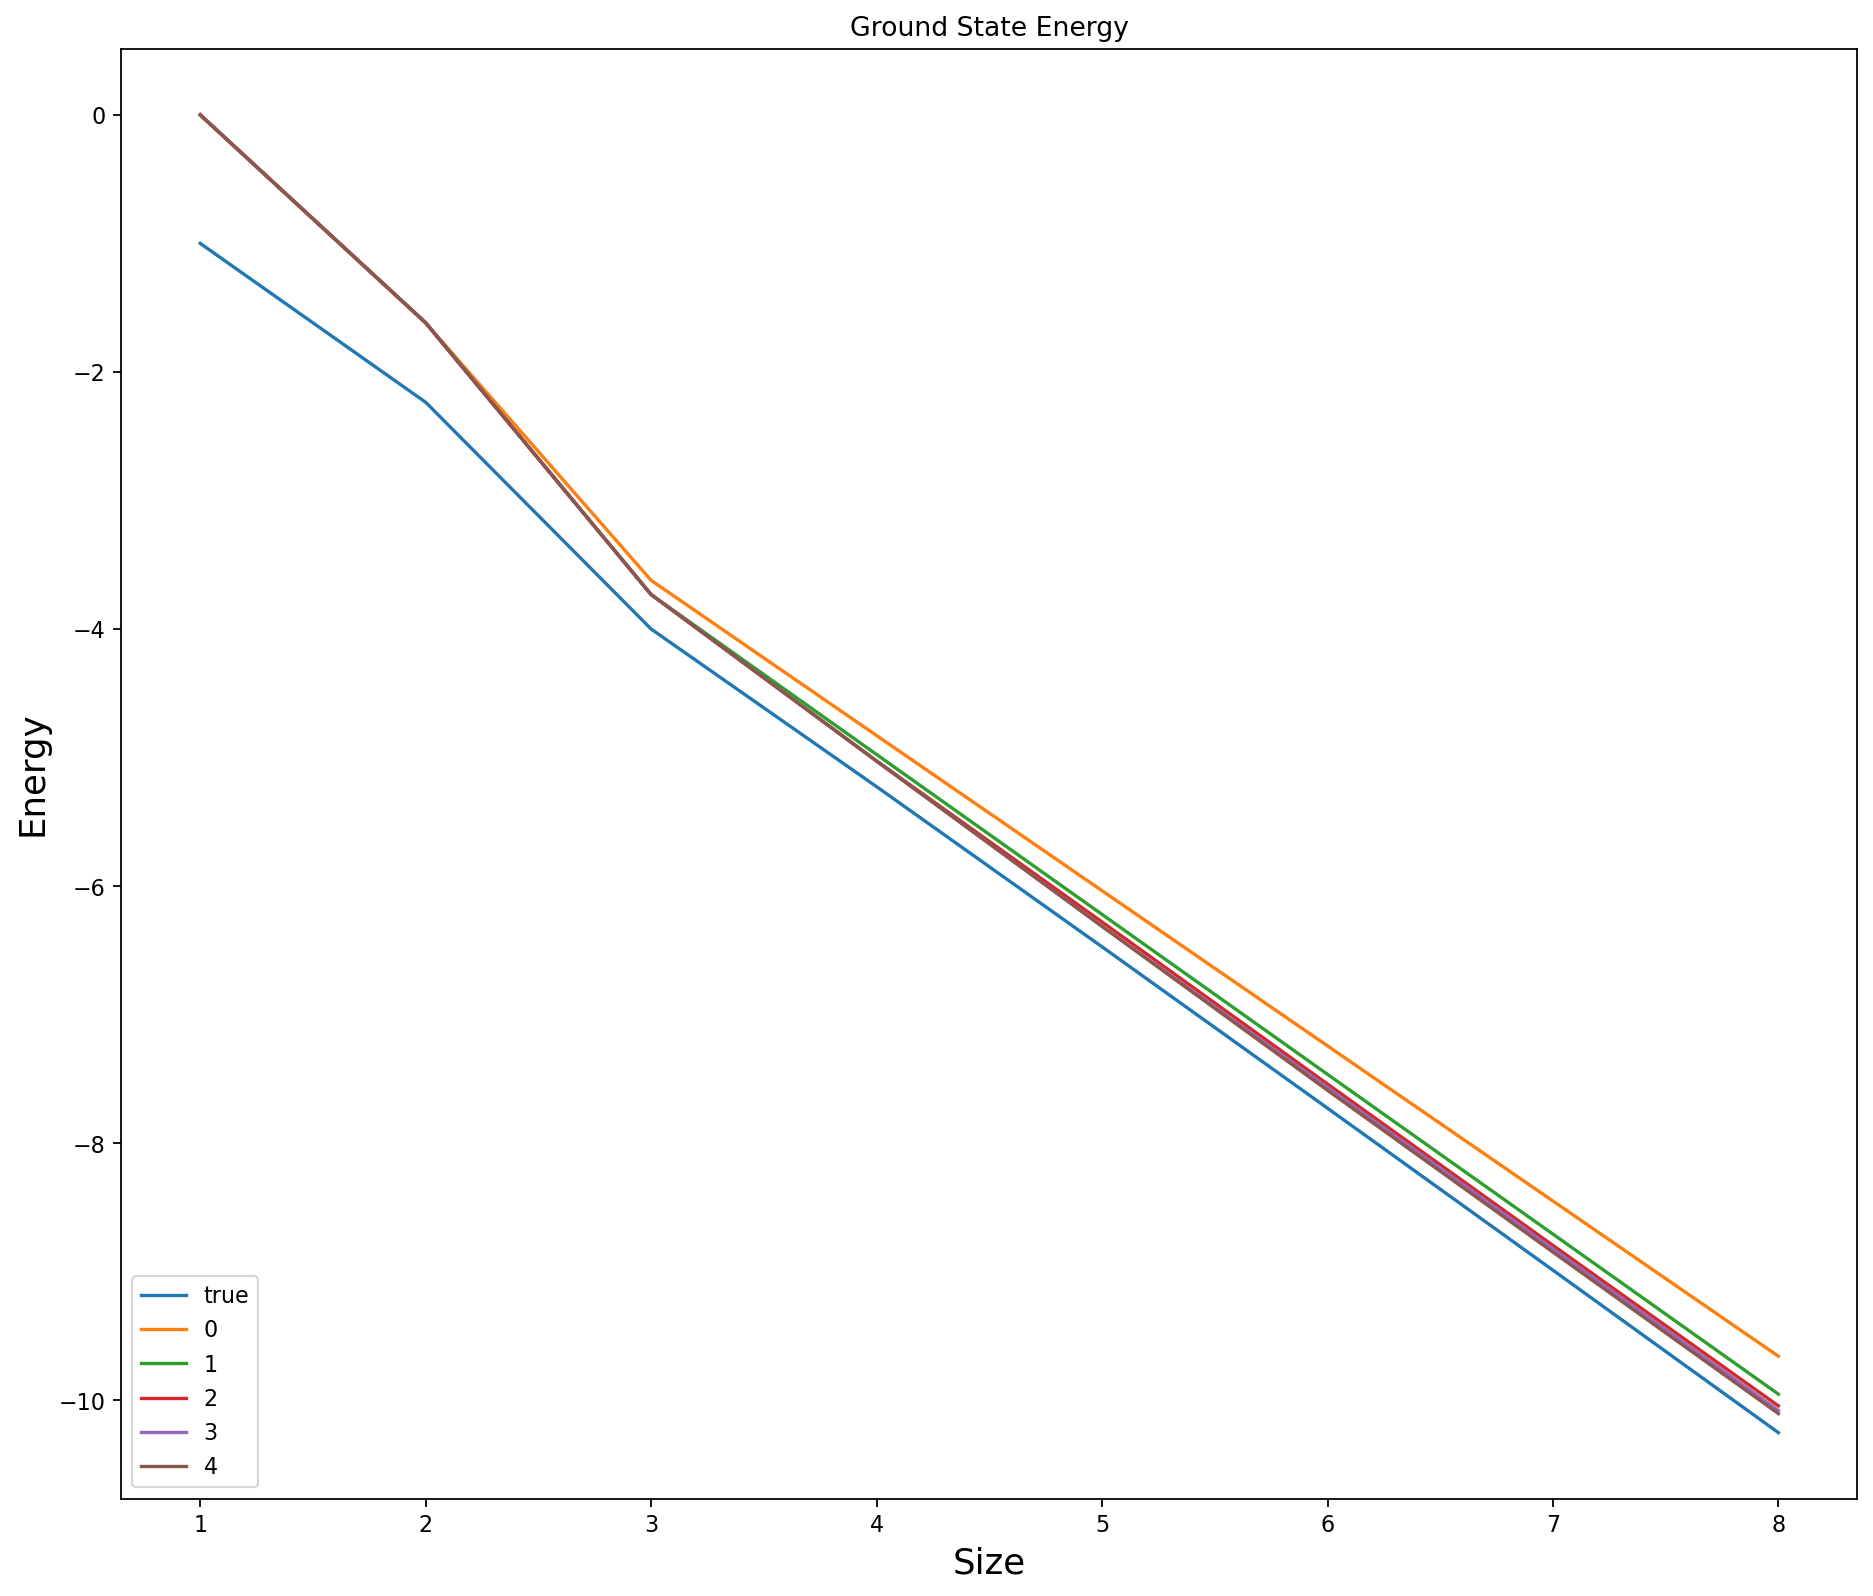

In [7]:
figure(figsize=(14, 12), dpi=160)

pylab.plot(list(range(1, len(trueGroundStates))), np.asarray(np.real(trueGroundStates[1:]), float), label="true")
for i in range(s):
    pylab.plot(list(range(1, len(groundStates[i]))), np.asarray(np.real(groundStates[i][1:]), float), label=str(i))
pylab.xlabel('Size', size = 16)
pylab.ylabel('Energy', size = 16)
pylab.title('Ground State Energy')
pylab.legend(loc='lower left') #more descriptive legend

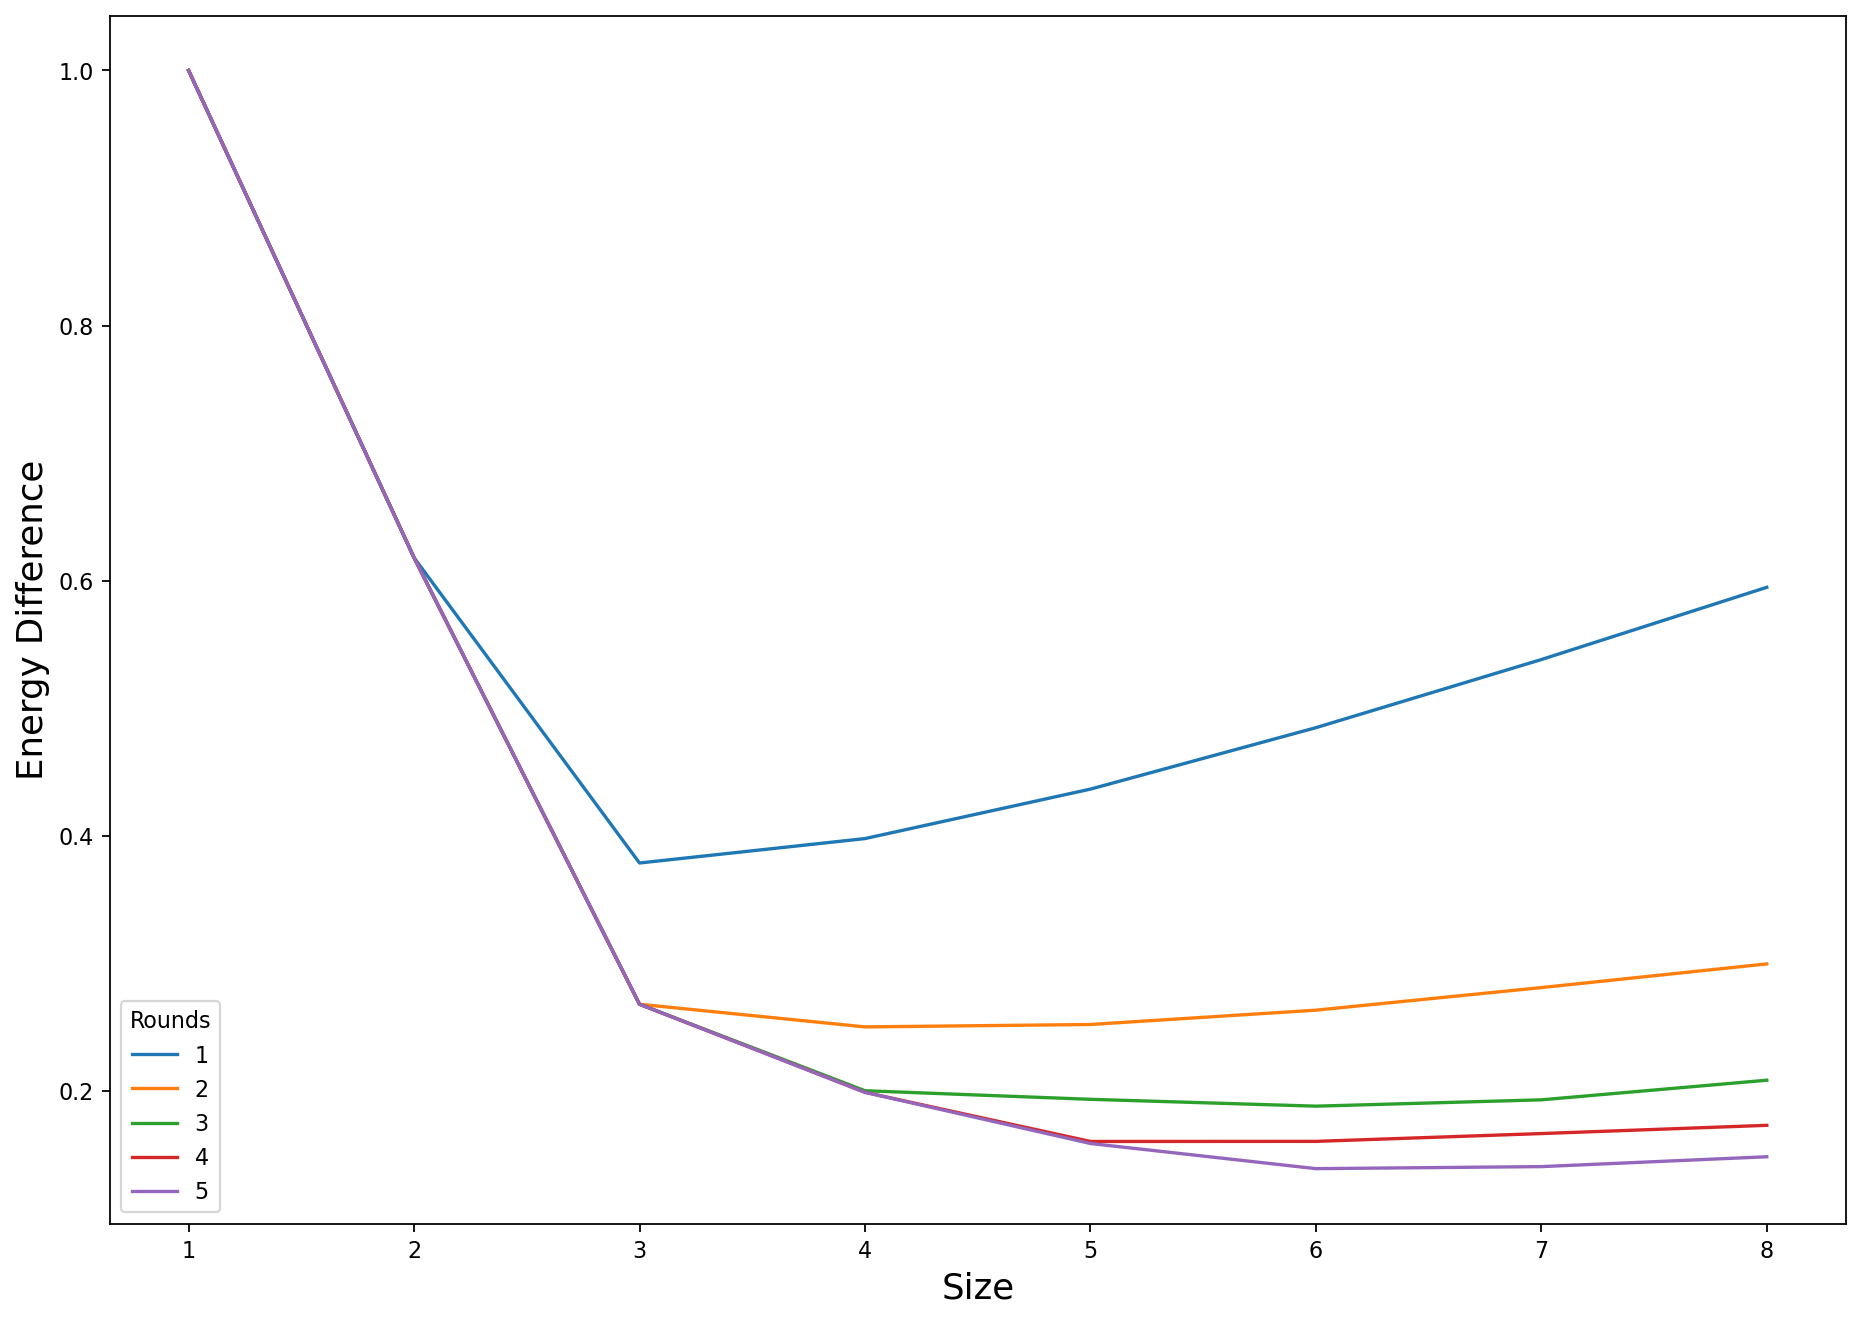

In [19]:
figure(figsize=(14, 10), dpi=160)

for i in range(s):
    diff = np.asarray(np.real(groundStates[i][1:]), float) - np.asarray(np.real(trueGroundStates[1:]), float)
    pylab.plot(list(range(1, len(groundStates[i]))), diff, label=f"{i + 1}")
pylab.xlabel('Size', size = 16)
pylab.ylabel('Energy Difference', size = 16)
pylab.legend(loc='lower left', title = 'Rounds') #more descriptive legend
pylab.savefig('plt5.png')

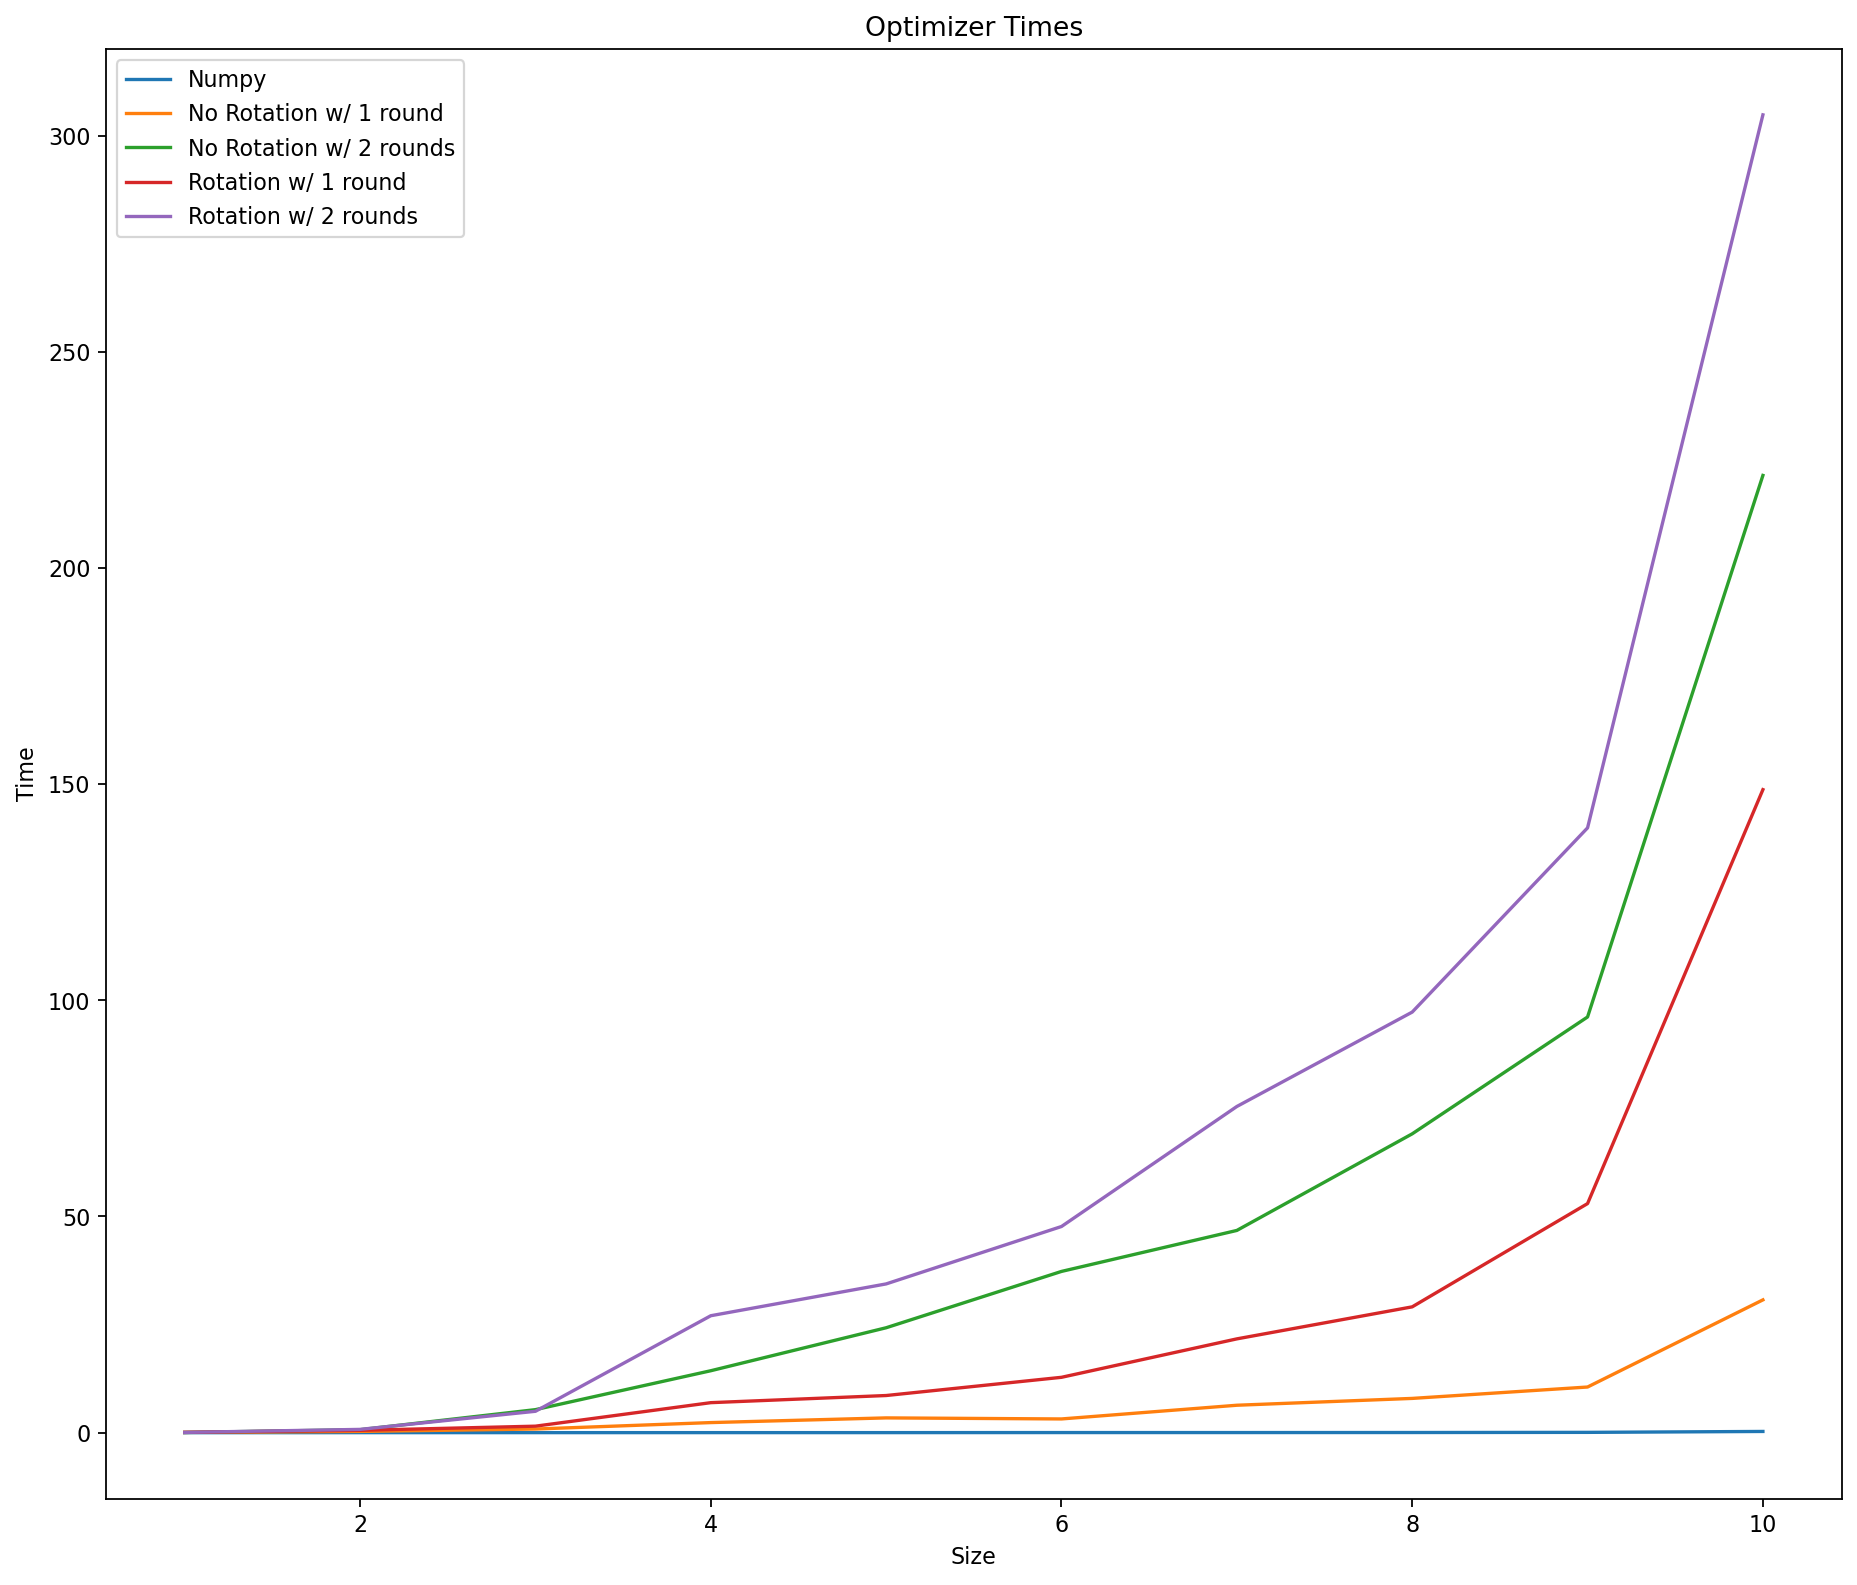

In [24]:
figure(figsize=(14, 10), dpi=160)

pylab.plot(list(range(1, n)),  trueTimes[1:], label='Numpy')
pylab.plot(list(range(1, n)),  np.sum(timesNR[0][1:], axis = 1), label='No Rotation w/ 1 round')
pylab.plot(list(range(1, n)),  np.sum(timesNR[1][1:], axis = 1), label='No Rotation w/ 2 rounds')
pylab.plot(list(range(1, n)),  np.sum(timesR[0][1:], axis = 1), label='Rotation w/ 1 round')
pylab.plot(list(range(1, n)),  np.sum(timesR[1][1:], axis = 1), label='Rotation w/ 2 rounds')

pylab.xlabel('Size')
pylab.ylabel('Time')
pylab.legend(loc='upper left')
pylab.savefig('plt5.png')

In [26]:
print(groundStatesR)

[array([ 9.99990000e+03,  0.00000000e+00, -1.61803399e+00, -2.61181727e+00,
       -4.82842704e+00, -4.92897905e+00, -7.24264052e+00, -7.34743845e+00,
       -9.65685368e+00, -9.76816945e+00, -1.20710675e+01]), array([ 9.99990000e+03,  0.00000000e+00, -1.61803399e+00, -2.73205077e+00,
       -4.97578148e+00, -5.50426746e+00, -7.46299932e+00, -7.93639300e+00,
       -9.93996102e+00, -1.04401567e+01, -1.24286255e+01]), None, None, None]


In [27]:
print(timesR)

[array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.23558044e-02, 1.29501820e-02, 1.43990517e-02, 1.22859478e-02,
        1.24590397e-02],
       [1.33116961e-01, 7.82048702e-02, 1.07846975e-01, 1.17075920e-01,
        1.03865147e-01],
       [2.96746016e-01, 3.04502010e-01, 2.84425259e-01, 2.84087896e-01,
        3.32806110e-01],
       [1.66673207e+00, 1.00558591e+00, 1.28926802e+00, 1.27399993e+00,
        1.70397997e+00],
       [2.43070722e+00, 1.66754985e+00, 1.85285783e+00, 1.66134810e+00,
        9.77429152e-01],
       [1.23832202e+00, 5.44739771e+00, 1.34904218e+00, 1.96592426e+00,
        2.80238986e+00],
       [2.79222989e+00, 3.43266106e+00, 4.00003195e+00, 5.80054092e+00,
        5.66688609e+00],
       [5.75787807e+00, 4.74018693e+00, 8.82363486e+00, 4.29038215e+00,
        5.48635602e+00],
       [1.16061492e+01, 1.12933261e+01, 1.37262719e+01, 6.04848623e+00,
        1.03055108e+01],
       [3.01464820e+01, 2.998

In [28]:
print(groundStatesNR)

[array([ 9.99990000e+03,  0.00000000e+00, -1.61803399e+00, -2.48443532e+00,
       -4.82842712e+00, -4.79829280e+00, -7.24264030e+00, -7.21372030e+00,
       -9.65685421e+00, -9.62791553e+00, -1.20710676e+01]), array([ 9.99990000e+03,  0.00000000e+00, -1.61803396e+00, -2.73205069e+00,
       -4.97606691e+00, -5.46824461e+00, -7.46395149e+00, -7.91463734e+00,
       -9.92739452e+00, -1.03966891e+01, -1.24363241e+01]), None, None, None]


In [29]:
print(timesNR)

[array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.10042095e-02, 1.46760941e-02, 1.08001232e-02, 8.52179527e-03,
        9.38296318e-03],
       [7.83059597e-02, 8.18040371e-02, 4.35972214e-02, 3.56791019e-02,
        5.05120754e-02],
       [2.12924004e-01, 1.50604010e-01, 1.84713364e-01, 1.49183989e-01,
        1.45041704e-01],
       [3.05730820e-01, 4.48586941e-01, 4.72543955e-01, 3.29031229e-01,
        7.75660992e-01],
       [5.06825209e-01, 1.07310796e+00, 6.94216013e-01, 5.66842079e-01,
        5.74589252e-01],
       [7.65600920e-01, 4.00556087e-01, 5.74880123e-01, 6.59720898e-01,
        7.72279024e-01],
       [1.73239017e+00, 1.13009930e+00, 1.43333793e+00, 8.78306866e-01,
        1.16879487e+00],
       [1.71141696e+00, 2.22370815e+00, 1.11717105e+00, 1.27917695e+00,
        1.59075093e+00],
       [2.96670175e+00, 1.73990321e+00, 1.95564008e+00, 1.98427606e+00,
        1.91057992e+00],
       [4.68682504e+00, 8.856

In [8]:
print(np.sum(times))

740.0238308906555
